# Assignment 3: Generative Adversarial Networks for X-RAY Classification

### Iris Vukovic

The [MedMNIST v2 dataset](https://medmnist.com/) is the MNIST of Medical Imaging containing a large-scale MNIST-like collection of standardized biomedical images.

Can we use this dataset to generate additional synthetic images? Can we condition the data generation on a label?

Let's try this in this exercise!

## Exercise:


#### 1. Definition of Research Question
We propose to explore one of the MedMNIST datasets and and define a suitable research question. This research question should contain GANs in its hypothesis and aiming towards solving a useful clinical task. Note: Normally, one would also look up the literature to see if the research question is already answered. For now, we skip this step

#### 2. Definition of a Baseline for the Research Question
To test our hypothesis, we need to gather experimental data to compare our solution against the state-of-the-art. The state-of-the-art is our baseline method.

#### 3. Implementation of the Baseline
We implement the baseline and try to do so making our code reusable for our method  (e.g. dataloaders, downstream classifer).  

#### 4. Testing the Baseline and Storage of Results
Now, we test out our baseline implementation and gather the corresponding empirical results and observe its results on our target performance metrics. Can these results be improved upon? Or, can similar results be aachieved with our more e.g. privacy-preserving, interpretable, generalizable, simpler, or more environment friendly solution?

#### 5. Implementation of our GAN Method
The method we hypothesise for the clinical task at hand would need to be implemented to allow testing its usefulness.

#### 6. Test of our GAN Method and Storage of Results
Now is the time to observe whether our method/intervention yields useful results, as we can readily compare it to our  baseline.

#### 7. Comparison of our Method and Baseline, Interpretation of Results
Now that we have generated some experimental data, we can interpret our results and clearly demonstrate whether our method was useful for the clinical task. We can now reject or accept our hypothesis.

#### 8. Reflective Account
What could be the reasons why our study did or did not succeed? What do you think are the limitations of our study? What can we learn and takeaway from this exercise? How should it inform our future work? What are the next things to try?

# 1. Definition of a Research question


### Review of MedMNIST Datasets

The MedMNIST dataset including 12 datasets for 2D and 6 datasets for 3D, in total containing 708,069 2D images and 10,214 3D images. The dataset is pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) images alongside the corresponding classification labels for diverse classification tasks (binary/multi-class, ordinal regression and multi-label). More information can be found in the [MedMNIST homepage](https://medmnist.com/).


### Choice of PneumoniaMNIST Dataset for our Study

We propose to use the PneumoniaMNIST dataset from MedMNIST, which contains to 5,856 chest x-rays (train: 4,708, validation: 524, test: 624). The reason for choosing this dataset is that its respective image classification task is binary (pneumonia/normal). Binary classification is likely to be simpler than multi-class classification for data augmentation purposes i.e. only two rather than multiple class-conditioned images need to be generated.
More information on the source of the Pneumonia dataset can be found [here](https://www.sciencedirect.com/science/article/pii/S0092867418301545).


### Definition of our Research Question

We follow the clinical task defined by the dataset providers, which is the classification of resampled chest xrays to diagnose lung pneumonia.

In this regard, our objective would be to maximize the performance of the classifier on the test dataset that should, in theory, resemble the real world distribution if we'd deploy our classifer into a clinical setting.

Now, we could train a GAN to augment the classfier's training data, which might improve classification performance.

However, the [reported performance](https://medmnist.com/) is already quite strong:

**ResNet-18: AUC: 0.944, ACC: 0.854**

There seems to be not that much to gain with GAN-based data augmentation (*Note: You may still try if you like*).

On the other hand, privacy preservation is a topic of immense importance in medical imaging. The pneumonia chest scans are from a pediatric patient cohort that paticularly requires special data protection. We could train a GAN to generate a synthetic dataset that would likely need less privacy protection than the real data.

*Note: Feel free to checkout the related topic of [differential privacy](https://ai.googleblog.com/2022/02/applying-differential-privacy-to-large.html) that provides a guarantee of privacy, among others, in neural networks.*

In this sense, we can now define our hypothesis:

**H1: Could we, instead of using real patient data, use only synthetic data to train our classifier and achieve comparable performance?**

# 2. Definition of a Baseline for the Research Question


##### We can now define our baseline metrics:
For example, a ResNet-18 trained on the real training dataset achieved AUC: 0.944 and ACC: 0.854

##### We define our method:
A simple CNN trained on a GAN-generated synthetic training dataset.

You are free to change the CNN model and use another architecture (e.g.,[see baseline](https://medmnist.com/))

##### How do we create the GAN-generated dataset?
Feel free to explore any idea you have. You may try out different (un)conditional GAN architectures and loss functions. Further below you will find some optional guidance.

# 3. Implementation of the Baseline

### Getting the Data
As always, you need access to the dataset. In this case you can download the pneumoniamnist.npz from [Zenodo](https://zenodo.org/record/5208230#.YmcLxtNBz0o). However, note that you can also access medMNIST data via the python packaging index ([pip](https://pypi.org/project/medmnist/)) or [Github](https://github.com/MedMNIST/MedMNIST) directly as pytorch dataset class.

For example:

In [ ]:
!pip3 install medmnist

In [2]:
import medmnist
from medmnist import INFO, Evaluator
info = INFO['pneumoniamnist']
DataClass = getattr(medmnist, info['python_class'])

task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

Let's further explore the dataset. We can start by printing dataset info and checking the label distribution.

In [3]:
# Download the dataset
train_dataset = DataClass(split='train', download=True)

# Print dataset information
print(train_dataset)

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.12MB/s]


Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


In [4]:
from collections import Counter

# Check the training label distribution
train_classes = [float(label) for _, label in train_dataset]
print (dict(Counter(train_classes)))

{1.0: 3494, 0.0: 1214}


<ipython-input-4-515e94852988>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_classes = [float(label) for _, label in train_dataset]


**Observation**: There are more people with pneumonia than not in the training set.

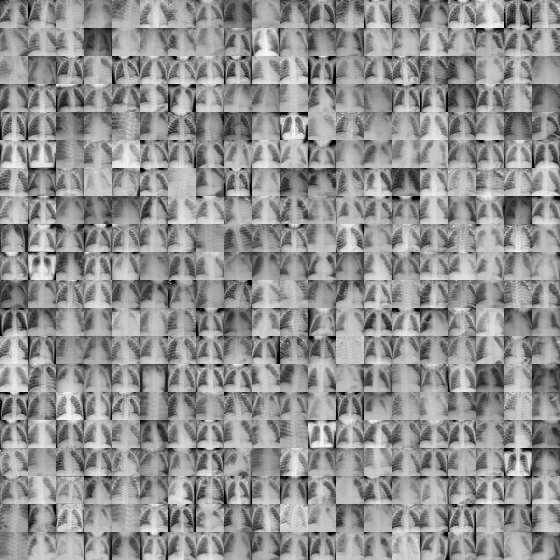

In [5]:
# Let's have a look at some of the training images.
train_dataset.montage(length=20)

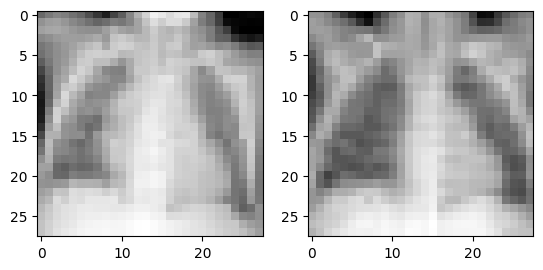

In [6]:
# Let's visually compare pneumial vs. healthy thoraic xray
# 0: normal, 1: pneumonia
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_dataset[0][0], cmap='gray') # pneumonia
ax[1].imshow(train_dataset[200][0],cmap='gray') # normal

### Baseline Model Implementation
To implement the baseline, we start with the [medMNIST github](https://github.com/MedMNIST/MedMNIST), where we can find a [Pytorch getting started notebook](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb).

In [7]:
# We define a simple CNN model for pneumonia classification
from torch import nn

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes-1)) # -1 if we use binary CLF

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Initialization of model, criterion and optimizer

In [8]:
from torch import optim

lr = 0.001

model_base = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_base.parameters(), lr=lr, momentum=0.9)


# 4. Testing the Baseline and Storage of Results


Defining hyperparameters and splitting of the dataset into test, validation, train.

In [9]:
data_flag = 'pneumoniamnist'
download = True  #  set to False if already loaded

NUM_EPOCHS = 5
BATCH_SIZE = 128
#lr = 0.001

info = INFO[data_flag]
#task = info['task']
#n_channels = info['n_channels']
#n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [10]:
from torchvision import transforms, utils
from torch.utils.data import DataLoader, Dataset

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# ingest torch datasets data into torch dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [11]:
print(len(val_dataset))
print(len(test_dataset))
print(len(train_dataset))

524
624
4708


Defining evaluation metrics such as the area under the receiver operating characteristic curve (AUROC) and the accuracy (ACC).

In [12]:
def getAUC(y_true, y_score, task):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == 'multi-label, binary-class':
        auc = 0
        for i in range(y_score.shape[1]):
            label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
            auc += label_auc
        ret = auc / y_score.shape[1]
    elif task == 'binary-class':
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = roc_auc_score(y_true, y_score)
    else:
        auc = 0
        for i in range(y_score.shape[1]):
            y_true_binary = (y_true == i).astype(float)
            y_score_binary = y_score[:, i]
            auc += roc_auc_score(y_true_binary, y_score_binary)
        ret = auc / y_score.shape[1]

    return ret

def getACC(y_true, y_score, task, threshold=0.5):
    '''Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == 'multi-label, binary-class':
        y_pre = y_score > threshold
        acc = 0
        for label in range(y_true.shape[1]):
            label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
            acc += label_acc
        ret = acc / y_true.shape[1]
    elif task == 'binary-class':
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = accuracy_score(y_true, y_score > threshold)
    else:
        ret = accuracy_score(y_true, np.argmax(y_score, axis=-1))

    return ret

Training the baseline pneumonia classification model.

In [13]:
from tqdm import tqdm

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model_base.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_base(inputs)

        targets = targets.float()
        outputs = outputs.float()

        print(targets.shape)
        print(outputs.shape)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

  3%|▎         | 1/37 [00:00<00:13,  2.65it/s]

torch.Size([128, 1])
torch.Size([128, 1])


  8%|▊         | 3/37 [00:00<00:05,  6.70it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 19%|█▉        | 7/37 [00:00<00:02, 10.80it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 24%|██▍       | 9/37 [00:00<00:02, 12.21it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 35%|███▌      | 13/37 [00:01<00:01, 13.48it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 41%|████      | 15/37 [00:01<00:01, 13.67it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 51%|█████▏    | 19/37 [00:01<00:01, 14.51it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 62%|██████▏   | 23/37 [00:01<00:00, 16.12it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 73%|███████▎  | 27/37 [00:02<00:00, 16.30it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 84%|████████▍ | 31/37 [00:02<00:00, 16.51it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 95%|█████████▍| 35/37 [00:02<00:00, 16.01it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|██████████| 37/37 [00:02<00:00, 13.78it/s]


torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([100, 1])
torch.Size([100, 1])


  0%|          | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|▌         | 2/37 [00:00<00:02, 15.48it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|█▌        | 6/37 [00:00<00:01, 16.56it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|██▏       | 8/37 [00:00<00:01, 16.16it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|███▏      | 12/37 [00:00<00:01, 16.56it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|███▊      | 14/37 [00:00<00:01, 17.07it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|████▎     | 16/37 [00:00<00:01, 17.65it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████▊     | 18/37 [00:01<00:01, 17.94it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|█████▍    | 20/37 [00:01<00:00, 17.99it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████▉    | 22/37 [00:01<00:00, 16.99it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 65%|██████▍   | 24/37 [00:01<00:00, 16.44it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|███████   | 26/37 [00:01<00:00, 16.33it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|████████  | 30/37 [00:01<00:00, 16.51it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|████████▋ | 32/37 [00:01<00:00, 16.44it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|█████████▏| 34/37 [00:02<00:00, 16.03it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|██████████| 37/37 [00:02<00:00, 16.65it/s]


torch.Size([100, 1])
torch.Size([100, 1])


  0%|          | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])


  5%|▌         | 2/37 [00:00<00:01, 17.66it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 11%|█         | 4/37 [00:00<00:01, 16.57it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|█▌        | 6/37 [00:00<00:01, 16.95it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|██▏       | 8/37 [00:00<00:01, 16.77it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|██▋       | 10/37 [00:00<00:01, 17.16it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|███▏      | 12/37 [00:00<00:01, 17.60it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|███▊      | 14/37 [00:00<00:01, 17.72it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|████▎     | 16/37 [00:00<00:01, 17.20it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████▊     | 18/37 [00:01<00:01, 16.40it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|█████▍    | 20/37 [00:01<00:01, 15.62it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████▉    | 22/37 [00:01<00:00, 15.43it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|███████   | 26/37 [00:01<00:00, 16.12it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|███████▌  | 28/37 [00:01<00:00, 16.21it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|████████  | 30/37 [00:01<00:00, 16.31it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|████████▋ | 32/37 [00:01<00:00, 16.43it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|█████████▏| 34/37 [00:02<00:00, 16.38it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|██████████| 37/37 [00:02<00:00, 16.57it/s]


torch.Size([100, 1])
torch.Size([100, 1])


  0%|          | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])


  5%|▌         | 2/37 [00:00<00:02, 14.08it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 11%|█         | 4/37 [00:00<00:02, 14.94it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|█▌        | 6/37 [00:00<00:01, 16.07it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 22%|██▏       | 8/37 [00:00<00:01, 16.19it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 27%|██▋       | 10/37 [00:00<00:01, 16.31it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 32%|███▏      | 12/37 [00:00<00:01, 16.48it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|███▊      | 14/37 [00:00<00:01, 17.02it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 43%|████▎     | 16/37 [00:00<00:01, 17.32it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████▊     | 18/37 [00:01<00:01, 17.51it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 54%|█████▍    | 20/37 [00:01<00:00, 17.37it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████▉    | 22/37 [00:01<00:00, 17.42it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 65%|██████▍   | 24/37 [00:01<00:00, 17.02it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|███████   | 26/37 [00:01<00:00, 17.07it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|███████▌  | 28/37 [00:01<00:00, 17.30it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|████████  | 30/37 [00:01<00:00, 17.40it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 86%|████████▋ | 32/37 [00:01<00:00, 16.58it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|█████████▏| 34/37 [00:02<00:00, 16.18it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


100%|██████████| 37/37 [00:02<00:00, 16.77it/s]


torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([100, 1])
torch.Size([100, 1])


  0%|          | 0/37 [00:00<?, ?it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


  5%|▌         | 2/37 [00:00<00:02, 14.23it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 11%|█         | 4/37 [00:00<00:02, 14.63it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 16%|█▌        | 6/37 [00:00<00:02, 15.27it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 27%|██▋       | 10/37 [00:00<00:01, 16.28it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 38%|███▊      | 14/37 [00:00<00:01, 16.40it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 49%|████▊     | 18/37 [00:01<00:01, 16.51it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 59%|█████▉    | 22/37 [00:01<00:00, 16.43it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 70%|███████   | 26/37 [00:01<00:00, 16.75it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 76%|███████▌  | 28/37 [00:01<00:00, 16.57it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 81%|████████  | 30/37 [00:01<00:00, 16.66it/s]

torch.Size([128, 1])
torch.Size([128, 1])


 86%|████████▋ | 32/37 [00:01<00:00, 16.32it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


 92%|█████████▏| 34/37 [00:02<00:00, 16.68it/s]

torch.Size([128, 1])
torch.Size([128, 1])


100%|██████████| 37/37 [00:02<00:00, 16.33it/s]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([100, 1])
torch.Size([100, 1])


Validation and test of the baseline model. This will let us know how good our model when trained on real data.

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch

# evaluation
def test(split, model):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    if split == 'train':
        data_loader = train_loader_at_eval
    elif split == 'val':
        data_loader = val_loader
    else:
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.to(torch.float32)
            #outputs = outputs.softmax(dim=-1)
            outputs = outputs.sigmoid()

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        acc = getACC(y_true, y_score, task)
        auc = getAUC(y_true, y_score, task)

        print('%s  auc: %.3f  acc:%.3f' % (split, auc, acc))
        return acc, auc, y_true, y_score


print('==> Evaluating baseline model ...')
acc, auc, y_true, y_score = test('train', model_base)
acc, auc, y_true, y_score = test('val', model_base)
acc, auc, y_true, y_score= test('test', model_base)

==> Evaluating baseline model ...
train  auc: 0.990  acc:0.953
val  auc: 0.987  acc:0.941
test  auc: 0.947  acc:0.873


**Observation**: Test accuracy is lower than validation accuracy, but I´m not sure why because the test and validation datasets were taken from the same dataset.

# 5 Definition and Implementation of our GAN Method

#### GAN Architecture Choice

You may use any GAN architecture and loss function you deem suitable.

To give some guidance, you could try a Deep Convolutional GAN ([DCGAN](https://arxiv.org/abs/1511.06434)). A helpful DCGAN implementation tutorial can be found [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

*Note that you will need to adjust the layers of the network to match the dimensions of the input data.*

DCGAN is an unconditional GAN architecture, which means that the data generation process is not controlled by the label information (pneumonia/normal). Hence, you would need to [extend the DCGAN architecture to a (DC)CGAN](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/) to be able to feed the labels as input into the generator and discriminator.

An alternative to the class-conditional GAN is to train an unconditional GAN twice - once on data with positive label and once on data with negative label.

*Note, instead of CGAN, you could also extend your DCGAN to the [Auxiliary Classifier GAN (ACGAN)] (https://arxiv.org/abs/1610.09585) architecture*.

Also, feel free to optionally use another deep generative model for this task instead of a GAN. For example, here you find a [tutorial](https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/classifier_free_guidance/2d_ddpm_classifier_free_guidance_tutorial.ipynb) for training a class-conditional diffusion model.

In [15]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [16]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For b&w images it is 1
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

#number of classes (for cDCGAN)
num_classes = 2

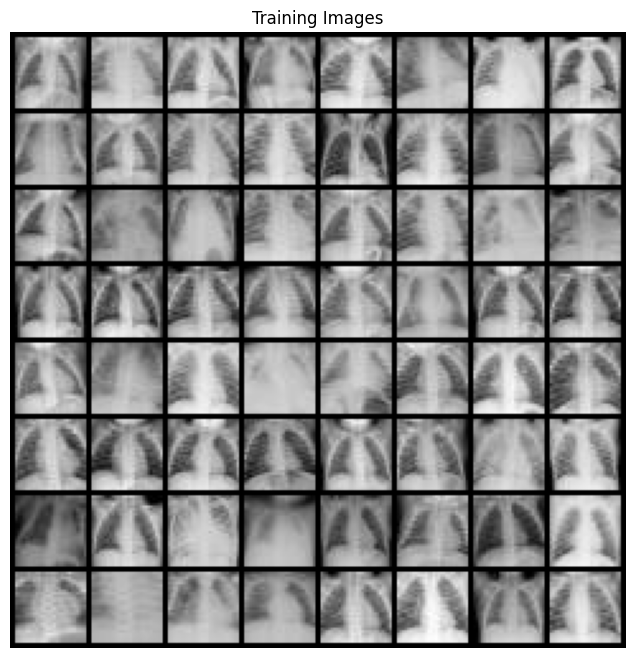

In [17]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [18]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input Z: (nz) → shape: (nz, 1, 1)
            nn.ConvTranspose2d(nz, 256, 7, 1, 0, bias=False),  # (256, 7, 7)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, nc, 4, 2, 1, bias=False),   # (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [21]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input: (nc, 28, 28)
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),  # (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 7, 1, 0, bias=False),   # (1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [22]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


In [23]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# to dynamically track fd score within the training loop in order to visualize later
!pip3 install pytorch-fid
from pytorch_fid import fid_score

In [ ]:
# Training Loop
fid_scores = []

real_dir = "fid_eval/real"
fake_dir = "fid_eval/fake"

os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_dir, exist_ok=True)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


        if epoch == 0 and i == 0:
            for idx in range(min(64, real_cpu.size(0))):
                vutils.save_image(real_cpu[idx], f"{real_dir}/real_{idx}.png", normalize=True)

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
        if epoch % 5 == 0 and i == len(train_loader) - 1:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            for idx in range(min(64, fake.size(0))):
                vutils.save_image(fake[idx], f"{fake_dir}/fake_{iters}_{idx}.png", normalize=True)

    fid_value = fid_score.calculate_fid_given_paths([real_dir, fake_dir],
                                                batch_size=64,
                                                device=device,
                                                dims=2048)
    fid_scores.append(fid_value)

    iters += 1

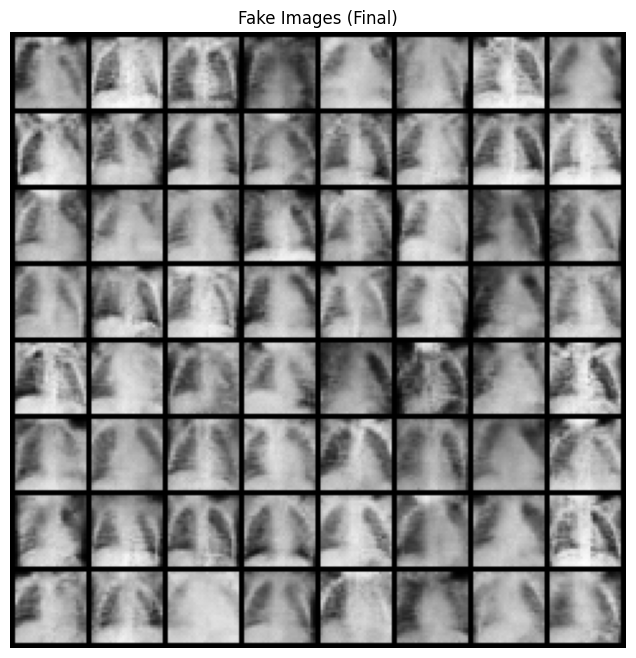

In [26]:
# Plot the most recent batch of fake images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images (Final)")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))  # CHW -> HWC
plt.show()

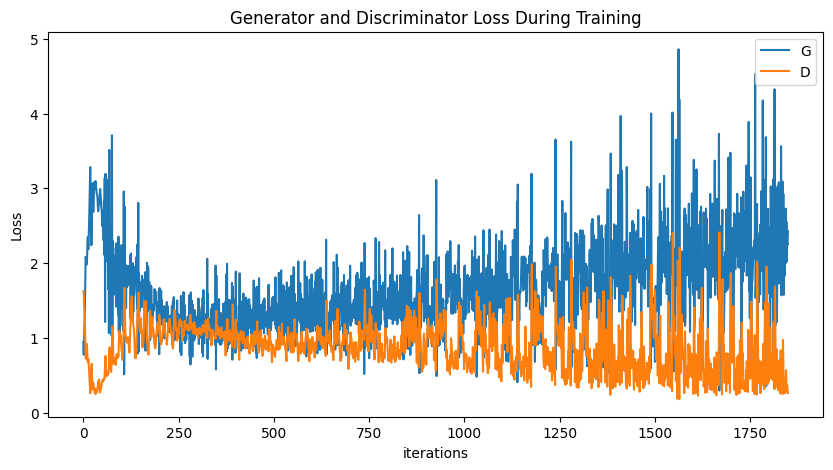

In [27]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Observation**: Maybe I should train for less epochs because the error seems to increase with more iterations.

#### Synthetic Data Evaluation Metric

Given our hypothesis, we need to evaluate the GAN based on the downstream task i.e. the classification performance (AUC, ACC). However, we should also report a fidelity and diversity estimate of our synthetic data. This is not only useful as additional metric, but also as stopping criterion of GAN training (e.g., n epochs without improvement). We propose you use the [Fréchet Inception Distance](https://github.com/mseitzer/pytorch-fid), but feel free to suggest other or additional metrics. Feel free to use existing packages such as the [pytorch-fid](https://pypi.org/project/pytorch-fid/) package.

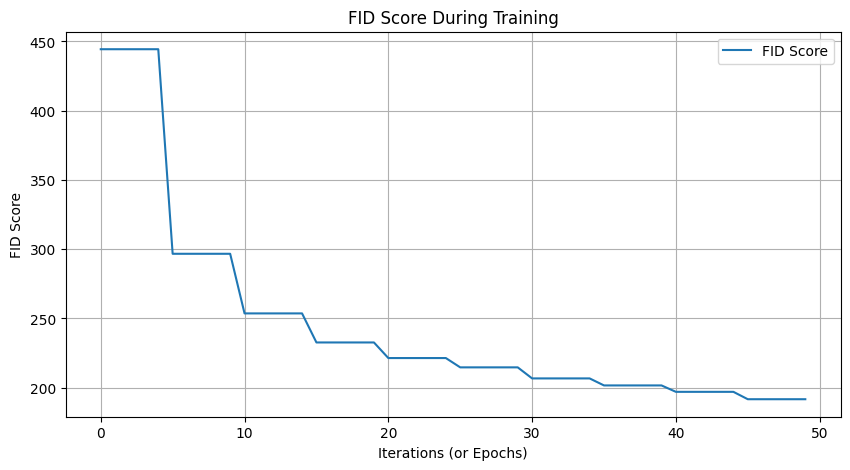

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label='FID Score')
plt.xlabel('Iterations (or Epochs)')
plt.ylabel('FID Score')
plt.title('FID Score During Training')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
from pytorch_fid import fid_score

fid_value = fid_score.calculate_fid_given_paths([real_dir, fake_dir],
                                                batch_size=64,
                                                device=device,
                                                dims=2048)
print(f"FID Score: {fid_value:.4f}")

100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


FID Score: 191.6679


**Note**: Less than 100 is ideal.

# Extending to a conditional DCGAN

In [31]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [32]:
class c_Generator(nn.Module):
    def __init__(self, nz, ngpu, nc, num_classes):
        super(c_Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.nc = nc
        self.num_classes = num_classes

        # Embedding layer for the label
        self.label_emb = nn.Embedding(num_classes, nz)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz * 2, 256, 7, 1, 0, bias=False),  # -> (256, 7, 7)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # (64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 32, 3, 1, 1, bias=False),   # (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 1, 3, 1, 1, bias=False),    #(1, 28, 28)
            nn.Tanh()
        )
    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels).view(-1, self.nz, 1, 1)

        # Add label embedding to the noise (they both have the same dimensions now)
        conditioned_input = torch.cat((noise, label_embedding), dim=1)  # (batch_size, 2*nz, 1, 1)

        '''print("Generator input noise shape:", noise.shape)
        print("Label embedding shape:", label_embedding.shape)
        print("Conditioned input shape:", conditioned_input.shape)'''

        return self.main(conditioned_input)

In [33]:
# Create the generator
netcG = c_Generator(nz, ngpu, nc, num_classes).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netcG = nn.DataParallel(netcG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netcG.apply(weights_init)

# Print the model
print(netcG)

c_Generator(
  (label_emb): Embedding(2, 128)
  (main): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13):

In [34]:
class c_Discriminator(nn.Module):
    def __init__(self, nc, ngpu, num_classes):
        super(c_Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.num_classes = num_classes

        # Embedding layer to convert label to image shape
        self.label_emb = nn.Embedding(num_classes, 28 * 28)
        nn.init.normal_(self.label_emb.weight, mean=0.0, std=0.02)

        self.main = nn.Sequential(
            nn.Conv2d(nc + 1, 64, 4, 2, 1, bias=False),  # (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),     # (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 3, 1, 1, bias=False),      # (256, 7, 7)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 3, 1, 1, bias=False),      # (512, 7, 7)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            #nn.Dropout2d(0.3),

            nn.Conv2d(512, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

        #self.sigmoid = nn.Sigmoid()

    def forward(self, img, labels):

        # Embed and reshape label to match image shape
        label_map = self.label_emb(labels).view(-1, 1, 28, 28)  # shape: (B, 1, 28, 28)

        conditioned_input = torch.cat((img, label_map), dim=1)

        out = self.main(conditioned_input)
        out = out.view(-1, 1)  # Flatten the output

        '''print("Discriminator input image shape:", img.shape)
        print("Label map shape:", label_map.shape)
        print("Concatenated input shape:", d_in.shape)'''

        return out

In [35]:
# Create the Discriminator
netcD = c_Discriminator(nc, ngpu, num_classes).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netcD = nn.DataParallel(netcD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netcD.apply(weights_init)

# Print the model
print(netcD)

c_Discriminator(
  (label_emb): Embedding(2, 784)
  (main): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (12): Sigmoid()
 

In [36]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_labels_healthy = torch.zeros(64, dtype=torch.long, device=device)     # Class 0
fixed_labels_pneumonia = torch.ones(64, dtype=torch.long, device=device)    # Class 1

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

lr = 1e-4


# Setup Adam optimizers for both G and D
optimizercD = optim.Adam(netcD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizercG = optim.Adam(netcG.parameters(), lr=lr, betas=(beta1, 0.999))

In [37]:
def show_generated_images(img_list, title="Generated Images"):
    # Display last generated batch of images
    if len(img_list) == 0:
        print("No generated images to display.")
        return

    img = img_list[-1]  # Get last grid
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
from shutil import copyfile
import tempfile

# Training Loop
real_dir = "reference_images/real"
fake_healthy_dir = "generated_images/fake_healthy"
fake_pneumonia_dir = "generated_images/fake_pneumonia"

os.makedirs(real_dir, exist_ok=True)
os.makedirs(fake_healthy_dir, exist_ok=True)
os.makedirs(fake_pneumonia_dir, exist_ok=True)

# Lists to keep track of progress
img_list_healthy = []
img_list_pneumonia = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netcD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 0.9, dtype=torch.float, device=device)
        # Forward pass real batch through D
        class_labels = data[1].squeeze().to(device)
        class_labels = class_labels.long()
        output = netcD(real_cpu, class_labels).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netcG(noise, class_labels)
        label.fill_(0.1)
        # Classify all fake batch with D
        output = netcD(fake.detach(), class_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizercD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if i % 2 == 0:
            netcG.zero_grad()
            label.fill_(0.9)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netcD(fake, class_labels).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizercG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


        if epoch == 0 and i == 0:
            # Display a grid of up to 64 real images
            '''real_grid = vutils.make_grid(real_cpu[:64], nrow=8, padding=2, normalize=True)

            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Real Images (First Batch)")
            plt.imshow(real_grid.permute(1, 2, 0).cpu().numpy())
            plt.show()'''

            for idx in range(min(64, real_cpu.size(0))):
                vutils.save_image(real_cpu[idx], f"{real_dir}/real_{idx}.png", normalize=True)

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
        if epoch % 5 == 0 and i == len(train_loader) - 1:
            with torch.no_grad():
                # Generate healthy class images
                fake_healthy = netcG(fixed_noise, fixed_labels_healthy).detach().cpu()
                grid_healthy = vutils.make_grid(fake_healthy, nrow=8, padding=2, normalize=True)
                img_list_healthy.append(grid_healthy)

                # Generate pneumonia class images
                fake_pneumonia = netcG(fixed_noise, fixed_labels_pneumonia).detach().cpu()
                grid_pneumonia = vutils.make_grid(fake_pneumonia, nrow=8, padding=2, normalize=True)
                img_list_pneumonia.append(grid_pneumonia)

                # Save images as before
                for idx in range(min(64, fake_healthy.size(0))):
                    vutils.save_image(fake_healthy[idx], f"{fake_healthy_dir}/fake_healthy_{iters}_{idx}.png", normalize=True)
                for idx in range(min(64, fake_pneumonia.size(0))):
                    vutils.save_image(fake_pneumonia[idx], f"{fake_pneumonia_dir}/fake_pneumonia_{iters}_{idx}.png", normalize=True)


    show_generated_images(img_list_healthy, "Generated: Healthy")
    show_generated_images(img_list_pneumonia, "Generated: Pneumonia")

    # Create a temporary directory for combined fake images
    with tempfile.TemporaryDirectory() as fake_combined_dir:
        # Copy fake healthy images
        for fname in os.listdir(fake_healthy_dir):
            src = os.path.join(fake_healthy_dir, fname)
            dst = os.path.join(fake_combined_dir, fname)
            copyfile(src, dst)

        # Copy fake pneumonia images
        for fname in os.listdir(fake_pneumonia_dir):
            src = os.path.join(fake_pneumonia_dir, fname)
            dst = os.path.join(fake_combined_dir, fname)
            copyfile(src, dst)

        # Now calculate FID between real and combined fake images
        fid_value = fid_score.calculate_fid_given_paths(
            [real_dir, fake_combined_dir],
            batch_size=64,
            device=device,
            dims=2048
        )

    fid_scores.append(fid_value)

    iters += 1


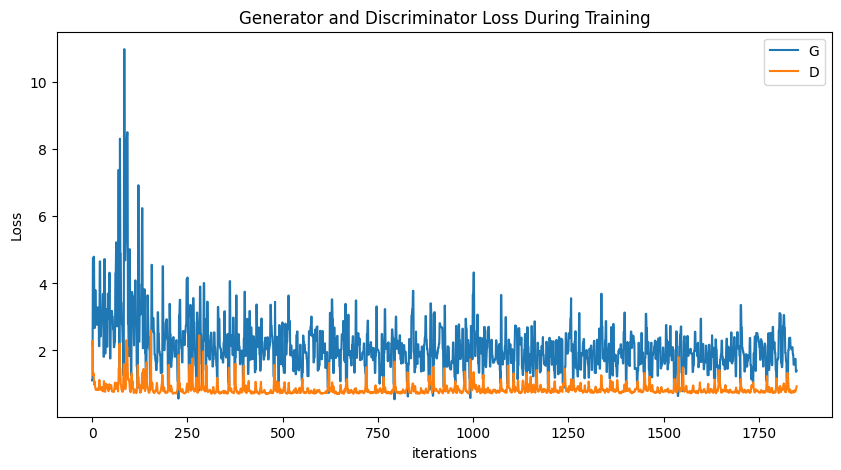

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

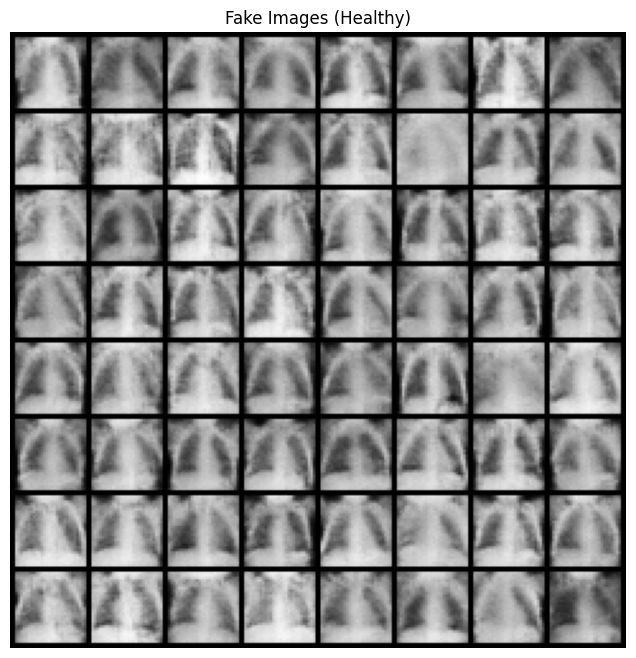

In [40]:
# Plot the most recent batch of fake images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images (Healthy)")
plt.imshow(np.transpose(img_list_healthy[-1], (1, 2, 0)))  # CHW -> HWC
plt.show()


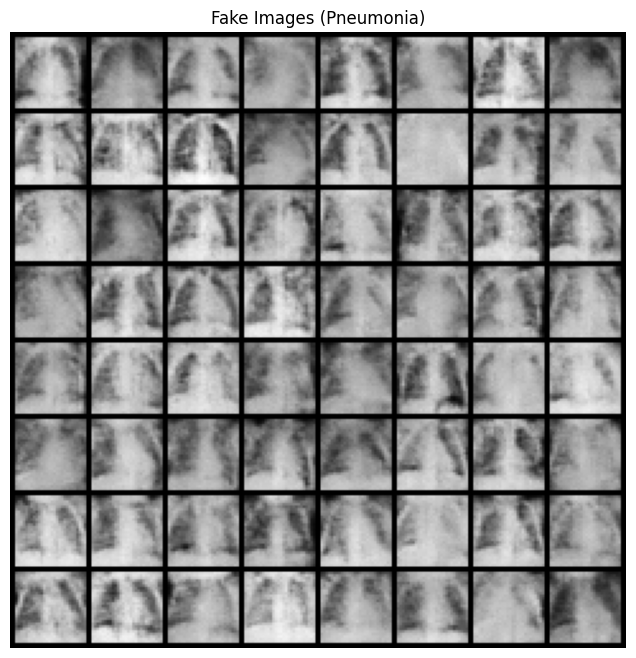

In [41]:
# Plot the most recent batch of fake images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images (Pneumonia)")
plt.imshow(np.transpose(img_list_pneumonia[-1], (1, 2, 0)))  # CHW -> HWC
plt.show()

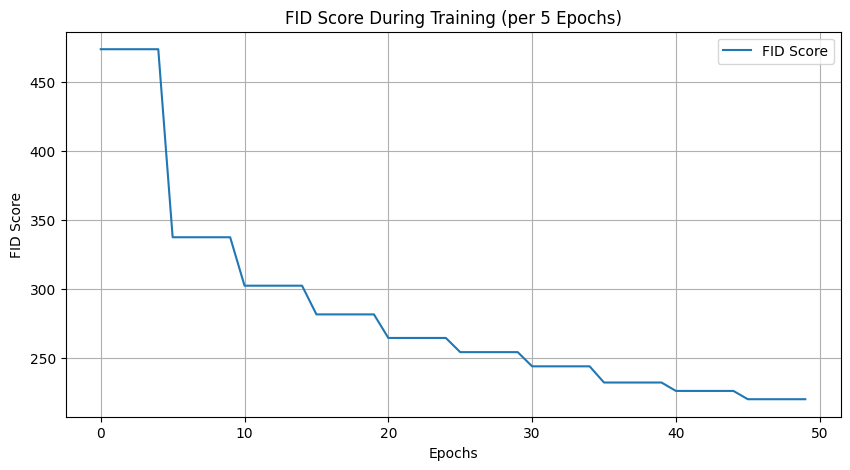

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(fid_scores[50:], label='FID Score')
plt.xlabel('Epochs')
plt.ylabel('FID Score')
plt.title('FID Score During Training (per 5 Epochs)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Test of our GAN Method and Storage of Results

Now that you have trained your GAN, it is time for the big moment of testing our hypothesis. To do so, a balanced classifier training dataset (50% pneumonia, 50% normal) consisting only of synthetic data is suggested. You may sample this dataset from your trained conditional generator, store on disc and load it again here.

In [45]:
# Number of images for each class
num_images = 5856 // 2  # 50% healthy and 50% pneumonia images

# Define batch size and z (latent vector size)
batch_size = 64
nz = 128  # Latent space size

# Create lists to store images for both classes
generated_imgs_label_0 = []  # Healthy class images
generated_imgs_label_1 = []  # Pneumonia class images

# Fixed noise and labels for healthy and pneumonia classes
fixed_noise = torch.randn(num_images, nz, 1, 1, device=device)
fixed_labels_healthy = torch.zeros(num_images, dtype=torch.long, device=device)  # Healthy label (0)
fixed_labels_pneumonia = torch.ones(num_images, dtype=torch.long, device=device)  # Pneumonia label (1)

# Generate the synthetic data
netcG.eval()
with torch.no_grad():
    for i in range(0, num_images, batch_size):
        noise_batch = fixed_noise[i:i+batch_size]
        label_batch_healthy = fixed_labels_healthy[i:i+batch_size]
        label_batch_pneumonia = fixed_labels_pneumonia[i:i+batch_size]

        # Generate images for healthy class
        fake_healthy = netcG(noise_batch, label_batch_healthy).cpu()
        # Generate images for pneumonia class
        fake_pneumonia = netcG(noise_batch, label_batch_pneumonia).cpu()

        generated_imgs_label_0.append(fake_healthy)
        generated_imgs_label_1.append(fake_pneumonia)

# Concatenate all generated images
generated_imgs_label_0 = torch.cat(generated_imgs_label_0, dim=0)
generated_imgs_label_1 = torch.cat(generated_imgs_label_1, dim=0)

# Save images on disk (optional)
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

for idx, img in enumerate(generated_imgs_label_0):
    vutils.save_image(img, f"{output_dir}/healthy_{idx}.png", normalize=True)

for idx, img in enumerate(generated_imgs_label_1):
    vutils.save_image(img, f"{output_dir}/pneumonia_{idx}.png", normalize=True)


Below some helper code to help define a torch CustomImageDataset Class based on the generated images that are loaded from disc.

In [46]:
from torch.utils.data import Dataset
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, imgs_label_0, imgs_label_1, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame(
            np.concatenate((np.zeros(len(imgs_label_0), dtype=int),
                            np.ones(len(imgs_label_1), dtype=int)))
        )
        self.images = np.concatenate((generated_imgs_label_0, generated_imgs_label_1))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx])
        label = np.array([self.img_labels.iloc[idx, 0]])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [51]:
# Apply transformations to the images (e.g., normalization)
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the dataset using generated images
train_gen_dataset = CustomImageDataset(generated_imgs_label_0, generated_imgs_label_1, transform=transform)

# Create DataLoader to load the dataset in batches
train_gen_loader = DataLoader(train_gen_dataset, batch_size=64, shuffle=True)



Training of the classifier, as was done above with real data, but now with the generated dataset.

In [ ]:
from tqdm import tqdm

model_new = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_new.parameters(), lr=lr, momentum=0.9)

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model_new.train()
    for inputs, targets in tqdm(train_gen_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model_new(inputs)

        targets = targets.float()
        outputs = outputs.float()

        print(targets.shape)
        print(outputs.shape)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

Test of the classifier, as was done above with real data, but now with the generated dataset.

In [58]:
print('==> Evaluating baseline model ...')
acc, auc2, y_true, y_score1 = test('train', model_new)
acc, auc2, y_true, y_score1 = test('val', model_new)
acc, auc2, y_true, y_score1 = test('test', model_new)

==> Evaluating baseline model ...
train  auc: 0.806  acc:0.744
val  auc: 0.768  acc:0.746
test  auc: 0.762  acc:0.628


# 7. Comparison of our Method and Baseline, Interpretration of Results

You may use some visualization techniques here to compare the baseline (i) with your method (ii). For example, it would be interesting to plot both ROC-AUC curves to visually compare them. Another visualization option is a confusion matrix for (i) and (ii).

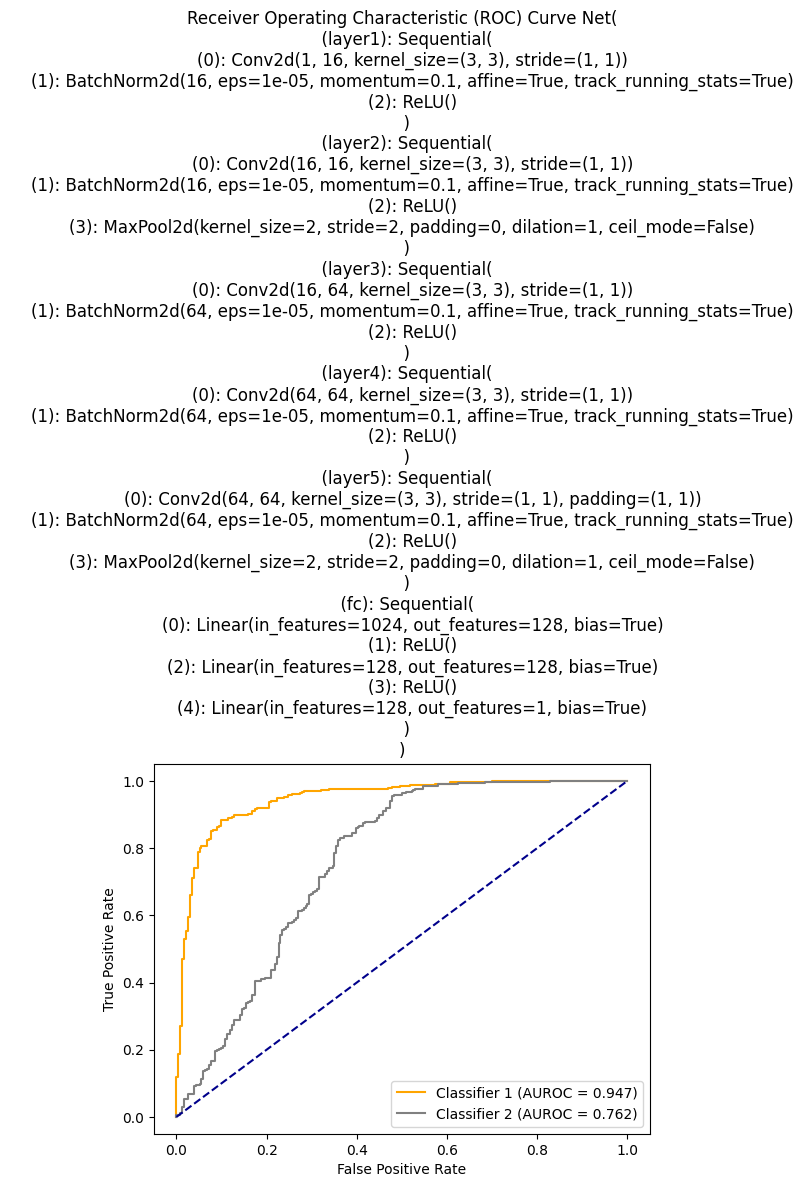

In [60]:
# example function for plotting multiple ROC-AUC curve in one figure.
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, thresholds1 = roc_curve(y_true, y_score)
fpr2, tpr2, thresholds2 = roc_curve(y_true, y_score1)

auc_score = roc_auc_score(y_true, y_score)
auc_score1 = roc_auc_score(y_true, y_score1)


def plot_roc_cur(fpr1, tpr1, fpr2, tpr2, auc, auc2, model_name):
    plt.plot(fpr1, tpr1, color='orange', label='Classifier 1 (AUROC = %0.3f)' % auc)
    plt.plot(fpr2, tpr2, color='gray', label='Classifier 2 (AUROC = %0.3f)' % auc2)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve {}'.format(model_new))
    plt.legend()
    plt.show()

plot_roc_cur(fpr1, tpr1, fpr2, tpr2, auc_score, auc_score1, model_new)

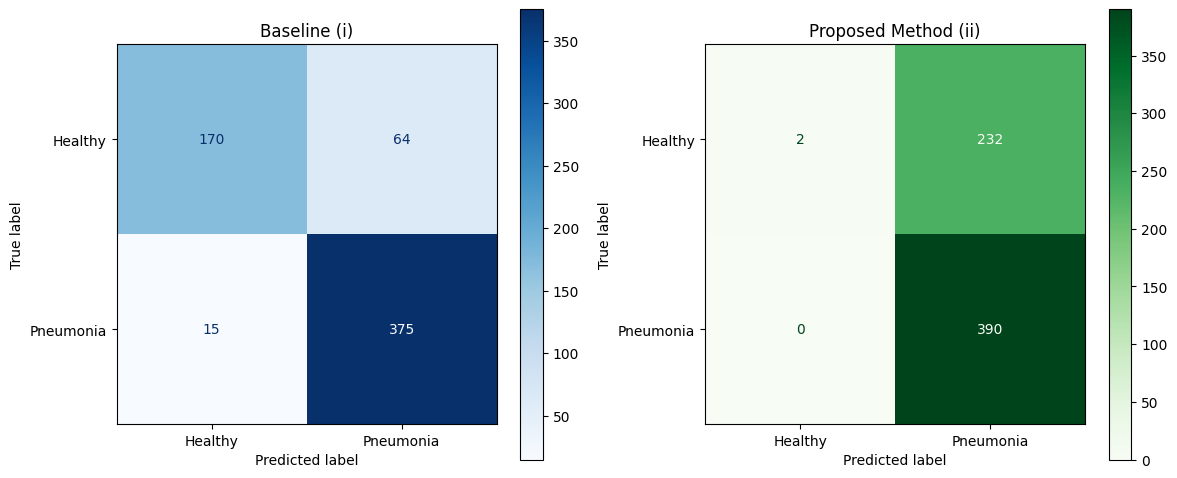

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred1, y_pred2, class_names=None):
    # Compute confusion matrices
    cm1 = confusion_matrix(y_true, y_pred1)
    cm2 = confusion_matrix(y_true, y_pred2)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=class_names)
    disp1.plot(ax=axes[0], values_format='d', cmap='Blues')
    axes[0].set_title("Baseline (i)")

    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_names)
    disp2.plot(ax=axes[1], values_format='d', cmap='Greens')
    axes[1].set_title("Proposed Method (ii)")

    plt.tight_layout()
    plt.show()

y_pred = (y_score >= 0.5).astype(int)
y_pred1 = (y_score1 >= 0.5).astype(int)

plot_confusion_matrices(y_true, y_pred, y_pred1, class_names=['Healthy', 'Pneumonia'])


**How would you interpret the results you achieved? Would you say your GAN-based privatization method is useful in practice? Do you reject or accept the hypothesis defined above?**

In theory, I believe that the GAN-based method is very useful for data privacy reasons. I see how it could be utilized a lot, not only in healthcare, but also in many other fields of research since privacy in data collection is a growing and important issue. We hypothesized that we could, instead of using real patient data, only use synthetic data to train our classifier and achieve a
comparable performance. According to the results we achieved, we should reject the hypothesis because I was not able to get comparable or similar results as with the model trained on real data. However, as seen above, the problem is that the model is not correctly identifying any healthy images and is generating a lot of false positives. The original dataset has way less healthy lung scans on it, so maybe if I tweaked my GAN architecture to train with more healthy lung samples (by adding more samples using data augmentation), I would get better results.

# 8. Reflective Account

**What could be the reasons why our study did or did not succeed? What do you think are the limitations of our study? What can we learn and takeaway from this exercise? How should it inform our future work? What would you try next?**

One of the limitations of our study is the lack of GPU units available for trying out and training different models. On GoogleColab the amount of GPU is restricted, so I can only train for a certain amount of time before I run out. For this reason, I wasn't able to test out more ideas and get better results in the end, but I do believe I could have reached comparable results with more time to experiment. In the future, in addition to generating more healthy samples to balance the dataset, I would also try using an ACGAN instead of a conditional DCGAN in order to get a more detailed output from the discriminator, so that it would include the class label of the input in addition to the probability of it being real or fake. I'm interested to see if that would affect the accuracy of the model trained on the generated dataset. From this exercise, I learned a lot about how GANs work and how sensitive they are to small changes in architecture due to the balance we are tryinig to reach between discrminator and generator.

Thank you for working on this study. We hope you enjoyed it and it was a good learning experience for you.

Please send any remarks or feedback you may have to [Oliver.Diaz@ub.edu](mailto:Oliver.Diaz@ub.edu) and CC [Richard.Osuala@ub.edu](mailto:Richard.Osuala@ub.edu).